In [342]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np 
import shap 
import matplotlib.pyplot as plt
from datetime import datetime

In [343]:
data = pd.read_csv('combined_data_more.csv')

In [344]:
timedata = pd.read_csv('timedata.csv')

In [345]:
data.head()

,Year,Month,Day,Mean Temp (°C)
0,2011,1,1,5.7
1,2011,1,2,-2.1
2,2011,1,3,-3.1
3,2011,1,4,-1.8
4,2011,1,5,-5.9


In [346]:
timedata.head()

,Year,Month,Day,Time (UTC),Temp (°C)
0,2021,1,1,00:00,1.2
1,2021,1,1,01:00,1.0
2,2021,1,1,02:00,0.8
3,2021,1,1,03:00,-1.4
4,2021,1,1,04:00,-1.4


In [247]:
data.isnull().sum()

Year              0
Month             0
Day               0
Mean Temp (°C)    0
dtype: int64

In [252]:
timedata.isnull().sum()   

Year          0
Month         0
Day           0
Time (UTC)    0
Temp (°C)     0
dtype: int64

In [304]:
timedata.dtypes

Year            int64
Month           int64
Day             int64
Time (UTC)    float64
Temp (°C)     float64
dtype: object

In [302]:
def time_to_float(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M')
    return time_obj.hour + time_obj.minute / 60.0

In [347]:
timedata["Time (UTC)"] = timedata["Time (UTC)"].apply(time_to_float)

In [348]:
X = data[["Year", "Month", "Day"]]

In [306]:
y = data["Mean Temp (°C)"]

In [307]:
X2 = timedata[["Year", "Month", "Day", "Time (UTC)"]]

In [308]:
y2 = timedata["Temp (°C)"]

In [349]:
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data['day_of_year'] = data['date'].dt.dayofyear

In [350]:
timedata['date'] = pd.to_datetime(timedata[['Year', 'Month', 'Day']])
timedata['day_of_year'] = timedata['date'].dt.dayofyear

<Axes: xlabel='date'>

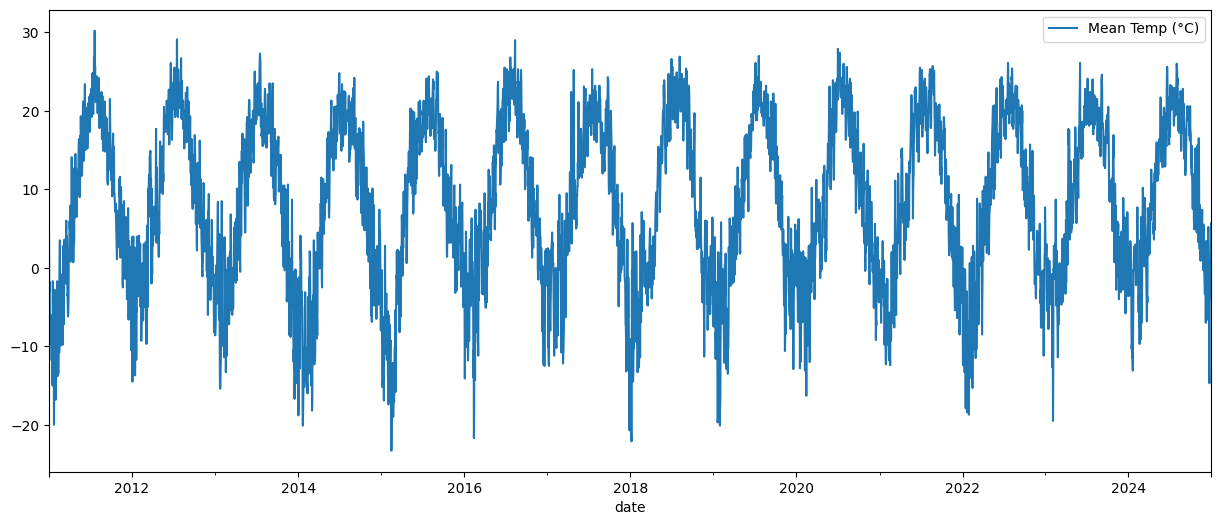

In [351]:
data.plot(x='date', y='Mean Temp (°C)', figsize=(15, 6))    

<Axes: xlabel='date'>

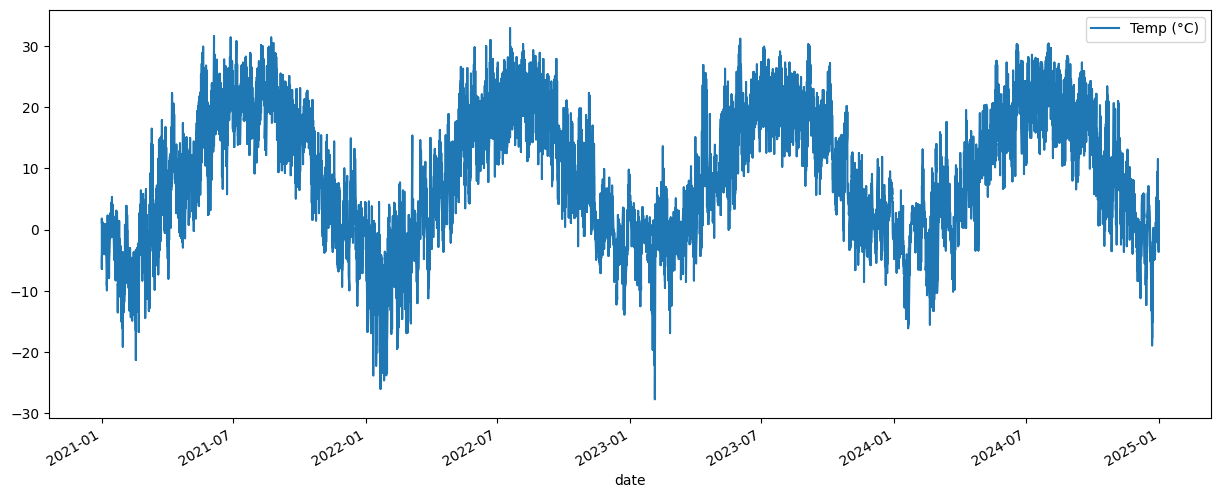

In [352]:
timedata = timedata.sort_values(by='date')
timedata.plot(x='date', y='Temp (°C)', figsize=(15, 6))

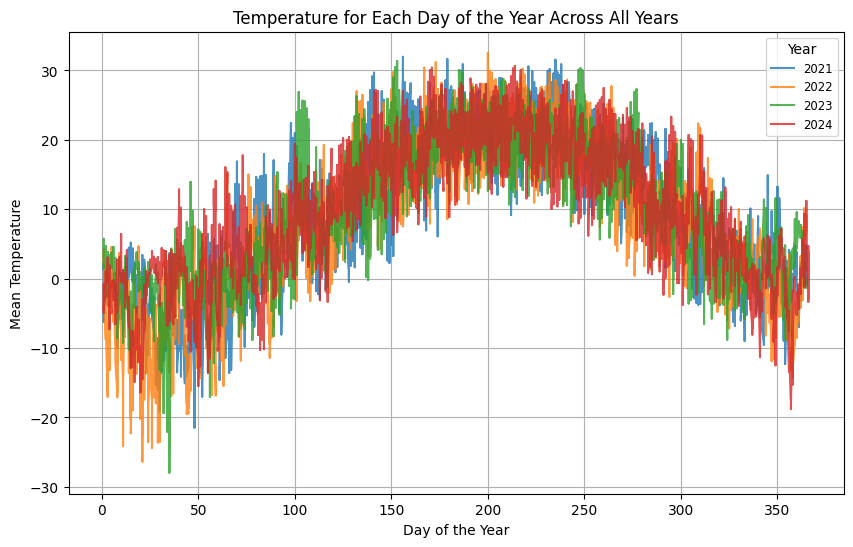

In [353]:
plt.figure(figsize=(10, 6))

# Loop through each unique year in the timedata dataset
for year in timedata['Year'].unique():
    yearly_data = timedata[timedata['Year'] == year]
    jitter = np.random.uniform(-0.4, 0.4, size=len(yearly_data))
    plt.plot(yearly_data['day_of_year'], yearly_data['Temp (°C)'] + jitter, label=year, alpha=0.8)

plt.title('Temperature for Each Day of the Year Across All Years')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Temperature')
plt.legend(title='Year', loc='upper right', fontsize='small', markerscale=2)
plt.grid(True)
plt.show()

In [314]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=80, shuffle=True)

In [315]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1, random_state=80, shuffle=True)

In [316]:
y_train.count, " ", y2_train.count

(<bound method Series.count of 4085    -0.9
 740      1.9
 4777     0.3
 4018     0.6
 2608     2.4
         ... 
 2423    19.5
 522     17.2
 2259    -0.4
 2982    -5.2
 1199    10.5
 Name: Mean Temp (°C), Length: 4602, dtype: float64>,
 ' ',
 <bound method Series.count of 29744    -3.6
 8555      7.0
 26259    11.1
 20608    26.0
 21738    25.8
          ... 
 15154    21.9
 8714     -1.6
 35027     5.0
 19366    24.4
 17583    13.9
 Name: Temp (°C), Length: 31557, dtype: float64>)

In [53]:
y_test.count, " ", y2_test.count

(<bound method Series.count of 4528    12.5
 74       2.5
 3148    19.1
 195     19.6
 2228    -2.3
         ... 
 4550    18.4
 3614     1.3
 678      4.0
 4421     1.2
 1639    14.8
 Name: Mean Temp (°C), Length: 512, dtype: float64>,
 ' ',
 <bound method Series.count of 12599    22.0
 34687     1.8
 9474      5.8
 21850    13.5
 10855     5.9
          ... 
 25358    19.6
 7947      2.2
 8226     14.9
 30753     2.3
 21775    12.8
 Name: Temp (°C), Length: 3507, dtype: float64>)

In [317]:
#{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 50, 'learning_rate': 0.2, 'gamma': 0.2, 'eta': 0.3, 'colsample_bytree': 1.0}
xgr = xgb.XGBRegressor(objective="reg:squarederror", subsample= 0.8, n_estimators= 1500, max_depth=30, learning_rate=0.1, eta= 0.1, colsample_bytree= 1.0)
xgr2 = xgb.XGBRegressor(objective="reg:squarederror", subsample= 1.0, n_estimators= 400, max_depth=50, learning_rate=0.05, eta= 0.2, colsample_bytree= 1.0, reg_alpha=0.5, reg_lambda=1.0, min_child_weight=1, gamma=0.6)

In [318]:
xgr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [319]:
xgr2.fit(x2_train, y2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=0.6, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [320]:
pred = xgr.predict(x_test)
pred2 = xgr2.predict(x2_test)

In [321]:
mae = np.abs(mean_absolute_error(y_test, pred))
print("MAE : % f " %(mae))

MAE :  2.366743 


In [322]:
mae2 = np.abs(mean_absolute_error(y2_test, pred2))
print("MAE : % f " %(mae2))

MAE :  0.816202 


In [323]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [324]:
dtrain2 = xgb.DMatrix(x2_train, label=y2_train)
dtest2 = xgb.DMatrix(x2_test, label=y2_test)

In [367]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 20,
    'eta': 0.2,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'min_child_weight': 1,
    'reg_lambda': 1.0,
    'reg_alpha': 0.2,
    'gamma': 0.8
    
}

In [355]:
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=4, verbose_eval=10)

[0]	test-rmse:9.67683
[10]	test-rmse:6.57418
[20]	test-rmse:4.93206
[30]	test-rmse:4.09163
[40]	test-rmse:3.64526
[50]	test-rmse:3.41291
[60]	test-rmse:3.29151
[70]	test-rmse:3.23823
[80]	test-rmse:3.20072
[90]	test-rmse:3.18850
[95]	test-rmse:3.18716


In [368]:
model2 = xgb.train(params, dtrain2, num_boost_round=1000, evals=[(dtest2, 'test')], early_stopping_rounds=2, verbose_eval=10)

[0]	test-rmse:9.85461


[10]	test-rmse:6.29953
[20]	test-rmse:4.17308
[30]	test-rmse:2.90402
[40]	test-rmse:2.14770
[50]	test-rmse:1.71823
[60]	test-rmse:1.46486
[70]	test-rmse:1.32390
[80]	test-rmse:1.24042
[90]	test-rmse:1.19330
[100]	test-rmse:1.16220
[110]	test-rmse:1.14738
[120]	test-rmse:1.13872
[130]	test-rmse:1.12992
[140]	test-rmse:1.12618
[150]	test-rmse:1.12189
[152]	test-rmse:1.12064


In [361]:
def evaluatemodel(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return ("MSE:", mse, "MAE:", mae, "R2:", r2)

In [363]:
evaluatemodel(xgr2, x2_test, y2_test)

('MSE:',
 1.2456975022976524,
 'MAE:',
 0.8162018804124134,
 'R2:',
 0.9883109308571809)

In [364]:
evaluatemodel(xgr2, x2_train, y2_train)

('MSE:',
 0.3757743382136308,
 'MAE:',
 0.4651159254816928,
 'R2:',
 0.9964799407878119)

In [369]:
evaluatemodel(model2, dtest2, y2_test)

('MSE:',
 1.2558315242227058,
 'MAE:',
 0.8303403738533984,
 'R2:',
 0.9882158377203974)

In [370]:
evaluatemodel(model2, dtrain2, y2_train)

('MSE:',
 0.4095326794248011,
 'MAE:',
 0.48964531787678883,
 'R2:',
 0.9961637101464822)

In [336]:
# can find best parameters for model using parameter search
param_dist = {
    'max_depth': [1, 3, 5, 10, 30, 50, 100, 200],
    'learning_rate': [0.05, 0.08, 0.1, 0.2],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200, 300, 400, 500],
    'objective': ['reg:squarederror'],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'min_child_weight': [1, 5, 10, 20],
    'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
    'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
}
randomsearch = RandomizedSearchCV(
    estimator=xgr2,
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',
    cv=10,
    verbose=1,
    n_jobs=-1
)

In [ ]:
randomsearch.fit(x2_train, y2_train)
print("Best Params: ", randomsearch.best_params_)
print("Best score: % f " % np.abs(randomsearch.best_score_))

In [45]:
#shap value stuff below

In [157]:
xgb_explainer = shap.Explainer(model2, x2_train)
shap_values = xgb_explainer(X2)

100%|===================| 17534/17544 [12:11<00:00]        

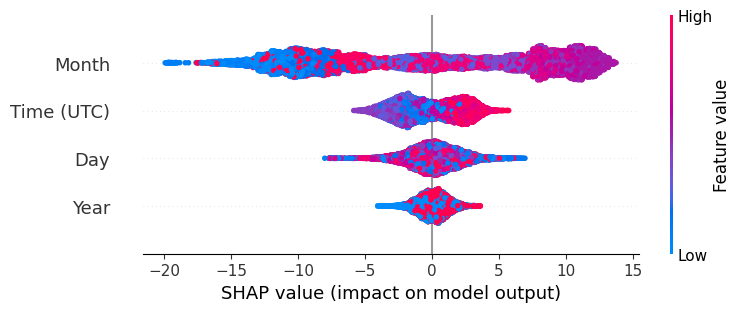

In [158]:
shap.plots.beeswarm(shap_values)

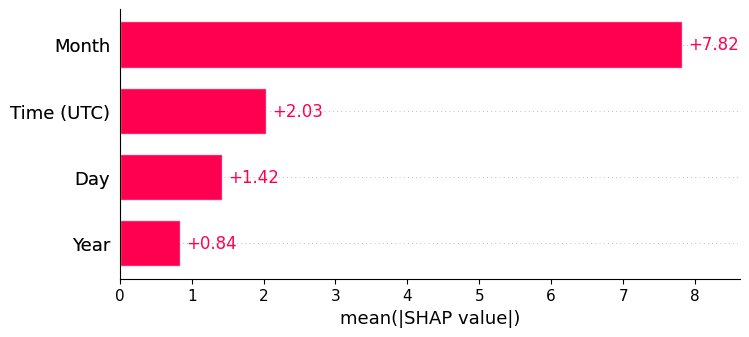

In [160]:
shap.plots.bar(shap_values)

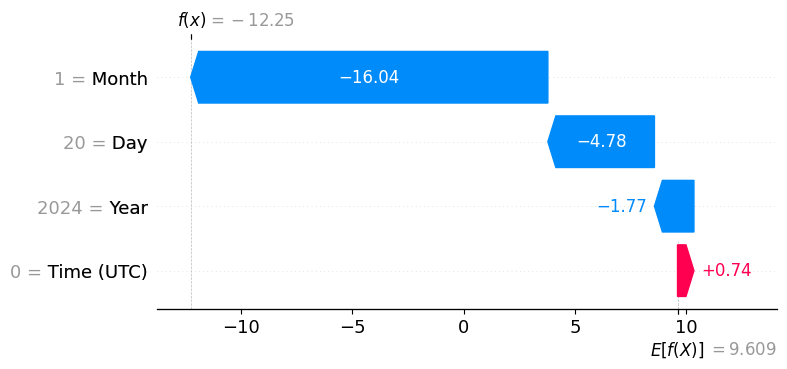

In [161]:
shap.plots.waterfall(shap_values[1200])

In [1]:
def predict_future_temp(year, month, day):
    future_date = pd.DataFrame({"Year": [year], "Month": [month], "Day": [day]})
    future_temp = model.predict(xgb.DMatrix(future_date))
    return future_temp[0]


In [2]:
def predict_future_temp_time(year, month, day, time):
    future_date = pd.DataFrame({"Year": [year], "Month": [month], "Day": [day], "Time (UTC)": [time]})
    future_temp = model2.predict(xgb.DMatrix(future_date))
    return future_temp[0]

In [ ]:
predict_future_temp(2025, 3, 25) 

In [374]:
predict_future_temp_time(2025, 3, 25, 17)

5.656879

In [ ]:
model2.save_model("xgboost_regressor_time_modelv2.json")